In [37]:
# Import Dependencies
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets import make_blobs
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_score
from matplotlib.colors import ListedColormap

cleaned_df2 = pd.read_pickle('cleaned_data_2.pkl')
outliers = pd.read_pickle('outliers.pkl')

Validation:
Are the clusters meaningful or would a simple rule work just as well?

Comparing to "dumb but reasonable approach":
See which counties are outliars for their EAL and doubly for their housing fragility - calculate using a simple normalized average of housing features by county like % units vacancy, % units without plumbing, % units built before 1940

In [38]:
# Take the average of housing fragility variables to create a fragility score for each county
housing_vars = [
    'pct_units_pre1940',
    'pct_overcrowded',
    'median_rent_pct_income',
    'pct_vacant_units',
    'pct_mobile_homes',
    'pct_lacking_plumbing'
]

cleaned_df2['fragility_score'] = cleaned_df2[housing_vars].mean(axis=1)

In [39]:
# Compare outliers housing fragility score to the their cluster average score

alrb_columns = [col for col in cleaned_df2.columns if col.startswith("ALRB")]

outliers = outliers.merge(cleaned_df2[["NAME", "cluster"] + alrb_columns + ["fragility_score"]], 
                          on=["NAME", "cluster"], how="left")

cluster_means = cleaned_df2.groupby("cluster")[alrb_columns + ["fragility_score"]].mean().reset_index()

outliers_vs_cluster = outliers.merge(
    cluster_means,
    on="cluster",
    suffixes=("", "_cluster_avg")
)

for col in alrb_columns:
    outliers_vs_cluster[f"{col}_delta"] = (
        outliers_vs_cluster[col] - outliers_vs_cluster[f"{col}_cluster_avg"]
    )
outliers_vs_cluster["fragility_delta"] = (
    outliers_vs_cluster["fragility_score"] - outliers_vs_cluster["fragility_score_cluster_avg"]
)

high_risk_outliers = outliers_vs_cluster[["NAME", "cluster", "fragility_delta"] + [f"{col}_delta" for col in alrb_columns]]


/var/folders/vd/kxtbrgs50mx5h4q6mzczwdgc0000gn/T/ipykernel_36134/3201983029.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


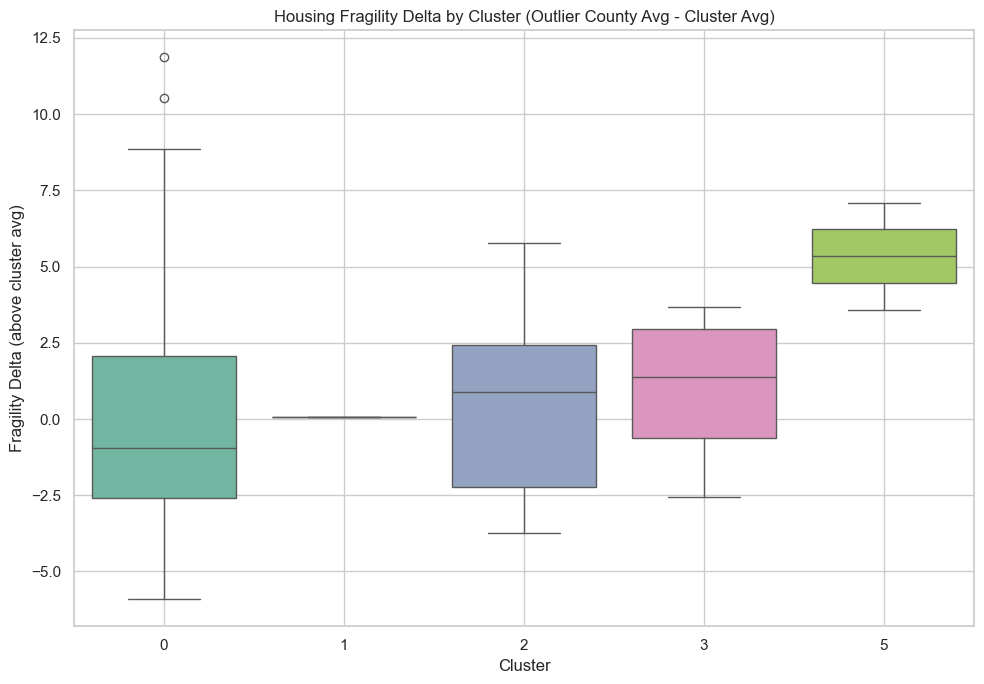

In [40]:
# Housing Fragility Delta Box plot by Cluster (outliers vs cluster)
# Difference between indv county's housing fragility & their cluster average housing fragility

plt.figure(figsize=(10, 7))
sns.boxplot(
    x='cluster', 
    y='fragility_delta', 
    data=outliers_vs_cluster, 
    palette='Set2'
)
plt.title("Housing Fragility Delta by Cluster (Outlier County Avg - Cluster Avg)")
plt.xlabel("Cluster")
plt.ylabel("Fragility Delta (above cluster avg)")
plt.grid(True)
plt.tight_layout()
plt.show()

Each boxplot represents the difference in housing fragility score between the overall cluster and the outliers in that cluster. As we can see, only the outliers in cluster 5 have a higher fragility score than the average county in cluster 5. In addition, there are notably two outliers in county 0 that have fragility scores 3 standard deviations above the mean fragility score for counties in cluster 0.  

In [41]:
# Compute hazard score for each county by summing hazards EAL & compute average hazard_score by cluster 
# Hazard_delta: difference between indv county's hazard score & their cluster average hazard score

from sklearn.preprocessing import StandardScaler

alrb_columns = [col for col in cleaned_df2.columns if col.endswith("ALRB")]
if not alrb_columns:
    raise ValueError("No ALRB columns found in cleaned_df2")

scaler = StandardScaler()
cleaned_df2_norm = cleaned_df2.copy()

if cleaned_df2[alrb_columns].isnull().values.any():
    raise ValueError("ALRB columns contain NaNs. Please handle missing values before standardizing.")

cleaned_df2_norm[alrb_columns] = scaler.fit_transform(cleaned_df2[alrb_columns])

cleaned_df2_norm["hazard_score"] = cleaned_df2_norm[alrb_columns].sum(axis=1)

cluster_hazard_avg = cleaned_df2_norm.groupby("cluster")["hazard_score"].mean().reset_index()
cluster_hazard_avg.rename(columns={"hazard_score": "hazard_score_cluster_avg"}, inplace=True)

outliers = outliers.merge(
    cleaned_df2_norm[["NAME", "cluster", "hazard_score"]],
    on=["NAME", "cluster"],
    how="left"
)

outliers = outliers.merge(
    cluster_hazard_avg,
    on="cluster",
    how="left"
)
outliers["hazard_delta_score"] = outliers["hazard_score"] - outliers["hazard_score_cluster_avg"]


In [42]:
# Merge fragility score with hazard score columns for outliers by cluster 
outliers_merged = outliers.merge(outliers_vs_cluster[["NAME", "fragility_score_cluster_avg", "fragility_delta"]],
                                on="NAME", how="left")

fragility_columns = ['fragility_score', 'fragility_score_cluster_avg', 'fragility_delta']
hazard_columns = ['hazard_score', 'hazard_score_cluster_avg', 'hazard_delta_score']

all_columns = outliers_merged.columns.tolist()
other_columns = [col for col in all_columns if col not in fragility_columns and col not in hazard_columns]
ordered_fragility_hazard = fragility_columns + hazard_columns
new_column_order = other_columns + ordered_fragility_hazard
outliers_merged = outliers_merged[new_column_order]

/var/folders/vd/kxtbrgs50mx5h4q6mzczwdgc0000gn/T/ipykernel_36134/3524548317.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="cluster", y="hazard_delta_score", data=outliers_merged, palette="Set2")


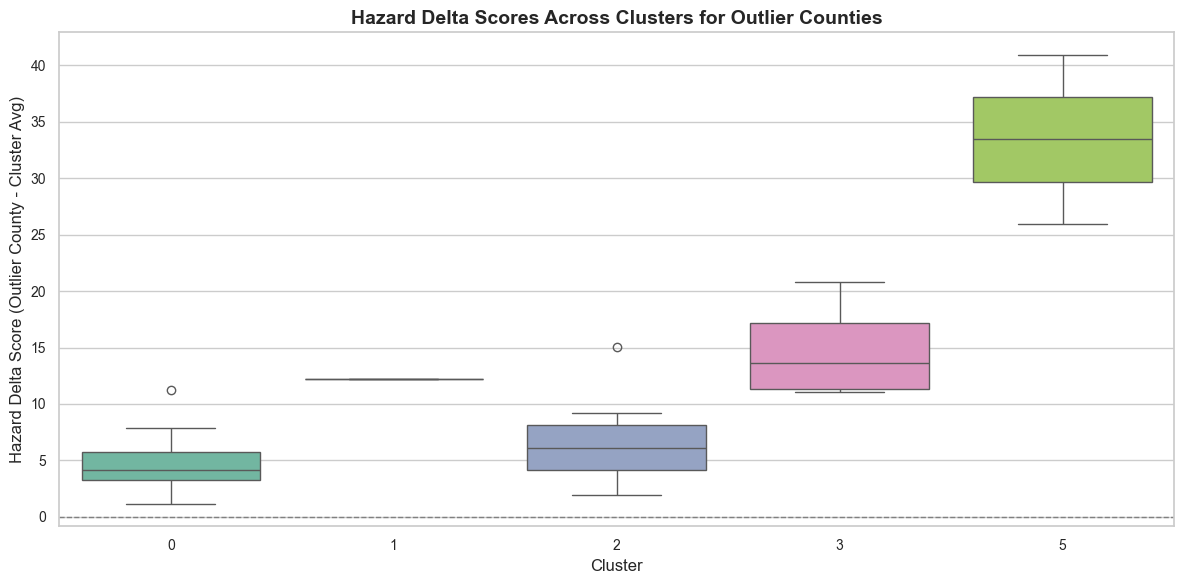

                         NAME  cluster        lat         lon  \
56  San Juan County, Colorado        5  37.764043 -107.676147   
57     Wheeler County, Oregon        5  44.726119 -120.027566   

    fragility_score  fragility_score_cluster_avg  fragility_delta  \
56        22.217341                    15.116947         7.100393   
57        18.708746                    15.116947         3.591799   

    hazard_score  hazard_score_cluster_avg  hazard_delta_score  
56     31.230476                  5.265345           25.965131  
57     46.208672                  5.265345           40.943327  


In [43]:
# Boxplot of Hazard Delta (Outlier County Avg - Cluster Avg) 
sns.set_theme(style="whitegrid")

plt.figure(figsize=(12, 6))
sns.boxplot(x="cluster", y="hazard_delta_score", data=outliers_merged, palette="Set2")

plt.title("Hazard Delta Scores Across Clusters for Outlier Counties", fontsize=14, weight='bold')
plt.xlabel("Cluster", fontsize=12)
plt.ylabel("Hazard Delta Score (Outlier County - Cluster Avg)", fontsize=12)
plt.axhline(0, color="gray", linestyle="--", linewidth=1)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

cluster_5_outliers = outliers_merged[outliers_merged['cluster'] == 5]
print(cluster_5_outliers)

Each boxplot represents the difference in composite hazard EAL building score (calculating by normalizing EAL Building Rates by column and summing them) between the overall cluster and the outliers in that cluster. As we can see, outliers in all clusters have a higher hazard score than the average county in their cluster. Again, cluster 5 shows the greatest difference betweeen the two outliars for that cluster and the cluster. So generally, the outliars in each cluster face a lot more expected loss to buildings than the average county in their cluster. 

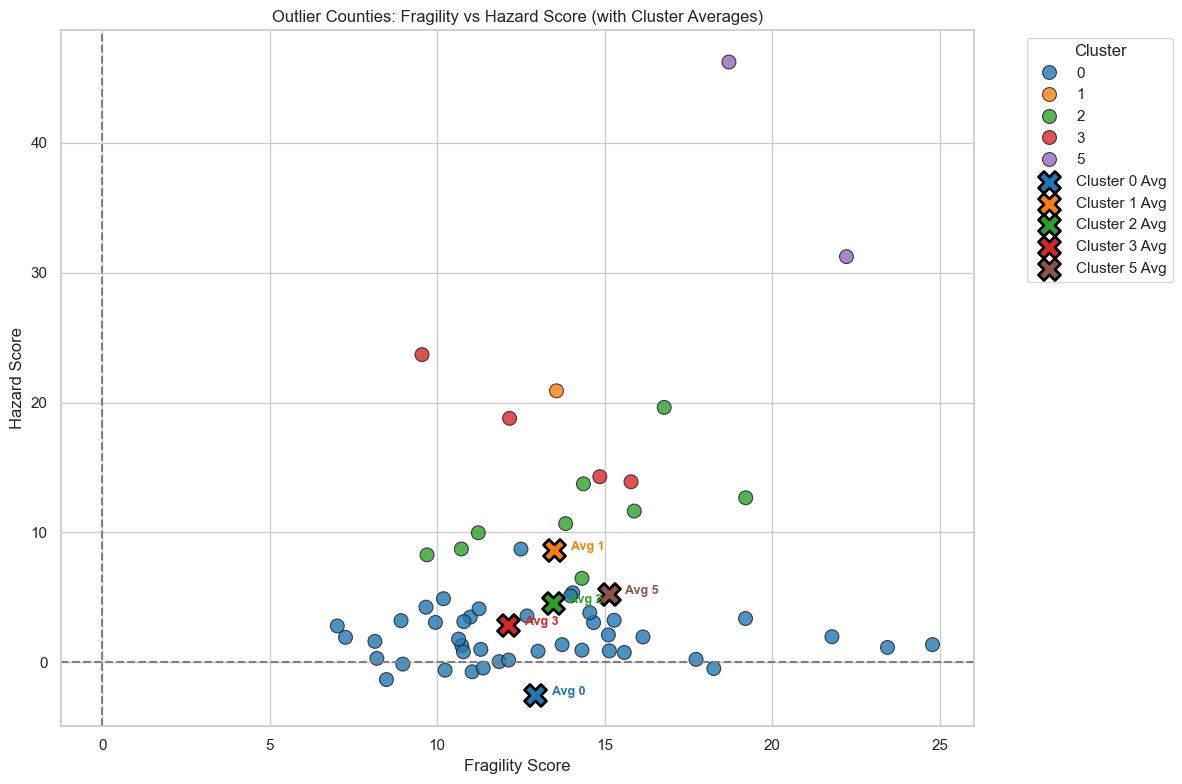

In [ ]:
# Plotting outlier counties hazard & fragility score with cluster averages to see distance

sns.scatterplot(
    data=outliers_merged,
    x="fragility_score",
    y="hazard_score",
    hue="cluster",
    palette="tab10",
    s=100,
    edgecolor="k",
    alpha=0.8,
    legend="full"
)

cluster_avgs = outliers_merged.groupby("cluster")[
    ["fragility_score_cluster_avg", "hazard_score_cluster_avg"]
].mean().reset_index()

for i, row in cluster_avgs.iterrows():
    plt.scatter(
        row["fragility_score_cluster_avg"],
        row["hazard_score_cluster_avg"],
        marker="X",
        s=250,
        color=sns.color_palette("tab10")[int(row["cluster"])],
        edgecolor="black",
        linewidth=2,
        label=f"Cluster {int(row['cluster'])} Avg"
    )
    plt.text(
        row["fragility_score_cluster_avg"] + 0.5,
        row["hazard_score_cluster_avg"],
        f"Avg {int(row['cluster'])}",
        fontsize=9,
        weight="bold",
        color=sns.color_palette("tab10")[int(row["cluster"])]
    )

plt.xlabel("Fragility Score")
plt.ylabel("Hazard Score")
plt.title("Outlier Counties: Fragility vs Hazard Score (with Cluster Averages)")
plt.axhline(0, linestyle="--", color="gray")
plt.axvline(0, linestyle="--", color="gray")
plt.grid(True)
plt.tight_layout()
plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


In [54]:
# Compare dumb-but-reasonable approach of finding counties with highest composite hazard score and highest fragility score

alrb_columns = [col for col in cleaned_df2.columns if col.endswith("ALRB")]
scaler = StandardScaler()
cleaned_df2_scaled = cleaned_df2.copy()
cleaned_df2_scaled[alrb_columns] = scaler.fit_transform(cleaned_df2[alrb_columns])
cleaned_df2_scaled["hazard_score"] = cleaned_df2_scaled[alrb_columns].sum(axis=1)

top_by_hazard = cleaned_df2_scaled.sort_values("hazard_score", ascending=False).head(58)
top_by_fragility = cleaned_df2_scaled.sort_values("fragility_score", ascending=False).head(58)

cleaned_df2_scaled["combined_score"] = (
    cleaned_df2_scaled["hazard_score"] + cleaned_df2_scaled["fragility_score"]
)
top_by_combined = cleaned_df2_scaled.sort_values("combined_score", ascending=False).head(58)

outlier_names = set(outliers["NAME"])

# Check overlap
hazard_overlap = set(top_by_hazard["NAME"]) & outlier_names
fragility_overlap = set(top_by_fragility["NAME"]) & outlier_names
combined_overlap = set(top_by_combined["NAME"]) & outlier_names

print(f"Hazard overlap: {len(hazard_overlap)}")
print(f"Fragility overlap: {len(fragility_overlap)}")
print(f"Combined overlap: {len(combined_overlap)}")


Hazard overlap: 7
Fragility overlap: 4
Combined overlap: 9


Low overlap suggests that clustering helps finds counties that are unusual within (likely geographic/hazard-based) clusters, but not necessarily the worst globally and is better for relative analysis.

# Examine the two outlier counties in cluster 5 that are significantly higher in risk and hazard scores from the cluster average
According to https://www.deirdredenaliphotography.com/blog/drought-and-wildfires-in-the-san-juan-mountains, San Juan County, Colorado is known for both its history of avalanches as well as more recent wildfire and drought. 
 
Wheeler County, Oregon

